In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-27 17:21:30.732826
numcores: 8


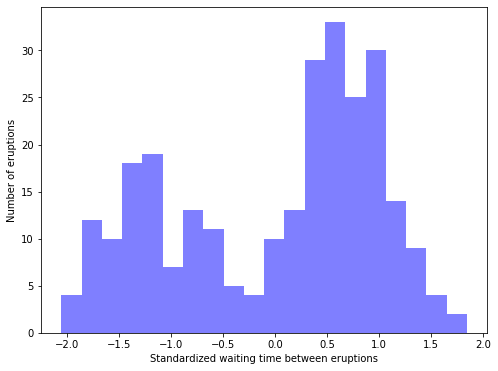

In [2]:
import pandas as pd
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()
old_faithful_df.head()

fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color='blue', lw=0, alpha=0.5);

ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

In [3]:
N = old_faithful_df.shape[0]

K = 30

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=old_faithful_df.std_waiting.values)
    

In [4]:
with model:
    trace = pm.sample(1000, random_seed=12345, init='advi',target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 424.45:   5%|▌         | 10616/200000 [00:08<02:39, 1188.10it/s]
Convergence achieved at 10700
Interrupted at 10,699 [5%]: Average Loss = 438.58
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, beta, alpha]
Sampling 4 chains, 316 divergences: 100%|██████████| 6000/6000 [01:31<00:00, 65.50draws/s]
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [10]:
pm.summary(trace,var_names=['w'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
w[0],0.500,0.148,0.300,0.691,0.054,0.042,8.0,7.0,10.0,362.0,1.33
w[1],0.421,0.156,0.179,0.709,0.041,0.037,15.0,9.0,18.0,94.0,1.39
w[2],0.066,0.145,0.000,0.399,0.013,0.009,120.0,120.0,170.0,160.0,1.04
w[3],0.008,0.023,0.000,0.034,0.001,0.000,1383.0,1383.0,283.0,323.0,1.00
w[4],0.003,0.009,0.000,0.012,0.000,0.000,1308.0,1308.0,248.0,269.0,1.01
w[5],0.001,0.005,0.000,0.004,0.000,0.000,1334.0,1334.0,241.0,303.0,1.01
w[6],0.001,0.002,0.000,0.002,0.000,0.000,1599.0,1599.0,224.0,310.0,1.01
w[7],0.000,0.001,0.000,0.001,0.000,0.000,2276.0,2276.0,206.0,307.0,1.01
w[8],0.000,0.001,0.000,0.000,0.000,0.000,2310.0,2310.0,204.0,349.0,1.00
w[9],0.000,0.000,0.000,0.000,0.000,0.000,2311.0,2311.0,198.0,358.0,1.00


In [11]:
pm.summary(trace,var_names=['mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.057,0.911,-1.264,0.757,0.387,0.290,6.0,6.0,9.0,100.0,1.44
mu[1],-0.438,0.901,-1.280,0.745,0.385,0.289,5.0,5.0,8.0,136.0,1.44
mu[2],-0.004,1.383,-2.021,1.933,0.072,0.056,369.0,302.0,491.0,618.0,1.01
mu[3],-0.027,2.115,-2.811,2.994,0.116,0.101,332.0,221.0,1186.0,523.0,1.00
mu[4],-0.000,1.885,-3.414,2.780,0.072,0.051,685.0,685.0,1056.0,648.0,1.01
mu[5],0.247,3.298,-3.497,3.790,0.229,0.168,207.0,194.0,731.0,483.0,1.01
mu[6],-0.132,3.120,-4.237,4.184,0.231,0.169,183.0,171.0,570.0,276.0,1.01
mu[7],0.040,2.423,-3.916,3.511,0.142,0.107,293.0,255.0,861.0,503.0,1.01
mu[8],0.131,2.419,-3.777,3.461,0.147,0.120,271.0,204.0,783.0,391.0,1.01
mu[9],-0.026,1.596,-2.960,2.752,0.054,0.047,862.0,583.0,1570.0,1065.0,1.00


In [6]:
#import warnings
#warnings.filterwarnings("ignore","Argument backend_kwargs has not effect in matplotlib.plot_dist")
#pm.sample_posterior_predictive(trace,100,model)

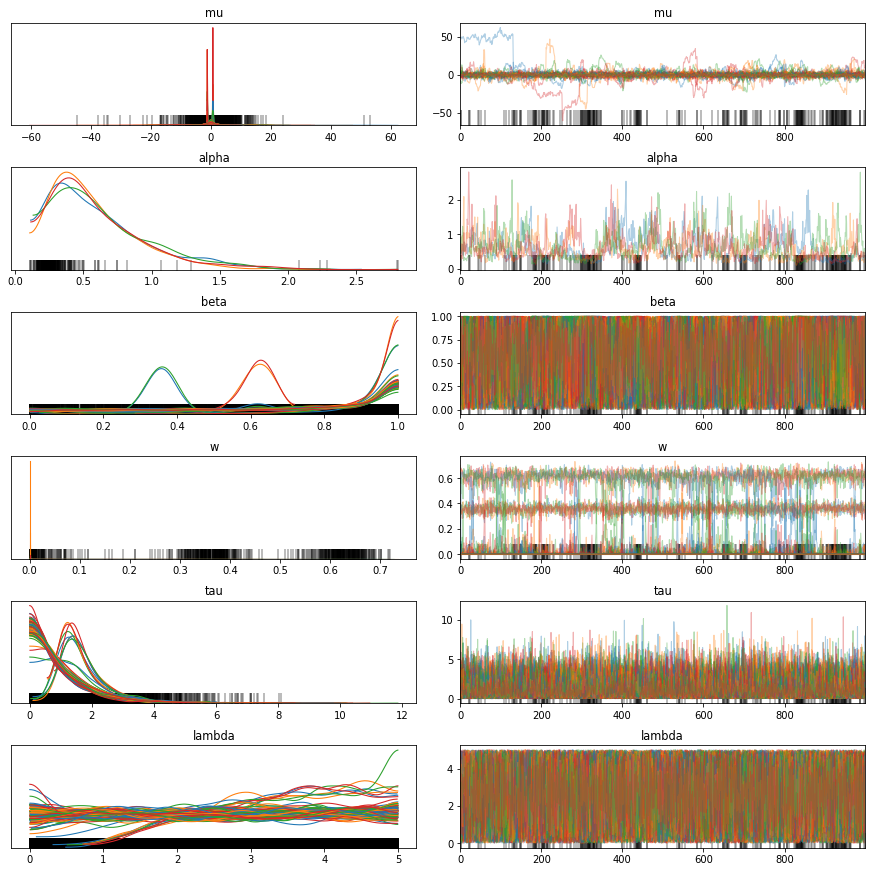

In [12]:
pm.traceplot(trace);

In [ ]:
a = pm.plot_posterior(trace,var_names=['w']);

In [23]:
wp = pm.sample_prior_predictive(
    samples=500,
    model=model,
    var_names=['w'],)

<BarContainer object of 30 artists>

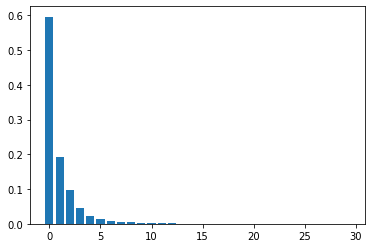

In [35]:
ys=wp['w'].mean(axis=0)
xs=np.arange(len(ys))
plt.bar(xs,ys)

In [38]:
wp = pm.sample_posterior_predictive(trace=trace,
    samples=500,
    model=model,
    var_names=['w'],)

/Users/aidasaglinskas/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 2319.53it/s]


<BarContainer object of 30 artists>

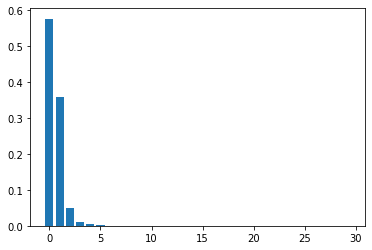

In [44]:
ys=wp['w'].mean(axis=0)
ys=np.sort(ys)[::-1]
xs=np.arange(len(ys))
plt.bar(xs,ys)